In [1]:
import os 
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
from langchain_google_genai import GoogleGenerativeAI

In [4]:
model=GoogleGenerativeAI(model="gemini-1.5-flash",api_key=os.getenv("GEMENI_APIKEY"))
model.invoke("HI")

'Hi there! How can I help you today?'

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

In [7]:
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [8]:
loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)

In [9]:
docs=loader.load()


In [10]:
docs[0].page_content

"🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hover

In [11]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20
)

In [12]:
new_docs=text_splitter.split_documents(documents=docs)

In [13]:
new_docs

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='with strong sectors in technology, 

In [14]:
len(new_docs)

48

In [15]:
db=Chroma.from_documents(new_docs,embeddings)

In [16]:
retriever=db.as_retriever(search_kwargs={"k":3})

In [17]:
retriever.invoke("Industrial growth of usa")

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

In [18]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [19]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected Topic")
    Reasoning:str=Field(description="selected Topic")

In [20]:
from langchain.output_parsers import PydanticOutputParser

In [21]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [22]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "selected Topic", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [25]:
from langchain.prompts import PromptTemplate

In [756]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseModel],operator.add]

In [757]:
def Supervisor(state:AgentState):
    question=state["messages"][-1]
    print("Question: ",question)
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related,Websurfing needed]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt=PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )
    chain=prompt|model|parser
    response=chain.invoke({"question":question})
    print("Parsed response: ",response)

    return{"messages":[response.Topic]}


In [758]:
state={"messages":["According to the web what is the most dangerous place on earth"]}

In [759]:
Supervisor(state)

Question:  According to the web what is the most dangerous place on earth
Parsed response:  Topic='Websurfing needed' Reasoning='The query explicitly asks for information from the web.'


{'messages': ['Websurfing needed']}

In [760]:
state={"messages":["What is the GDP of USA?"]}
Supervisor(state)

Question:  What is the GDP of USA?
Parsed response:  Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'


{'messages': ['USA']}

In [761]:
def Router(state: AgentState):
    print("->ROUTER->")
    last_message = state["messages"][-1]
    print("last_message:", last_message)

    if "usa" in last_message.lower():
        return "RAG Call"
    elif "not related" in last_message.lower():
        return "LLM Call"
    elif "web" in last_message.lower():
        return "WEB Call"
    else:
        return "LLM Call"

In [762]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [763]:
def RAG(state:AgentState):
    print("->RAG Call->")
    question=state["messages"][-1]
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    rag_chain=(
        {"context":retriever|format_docs,"question":RunnablePassthrough()}|prompt|model|StrOutputParser()
    )
    result=rag_chain.invoke(question)
    return {"messages":[result]}


In [764]:
def LLM(state: AgentState):
    print("->LLM Call->")
    question=state["messages"][0]
    complete_query="Answer the following question with your knowledge of the real world . Following is the user question: "+question
    response=model.invoke(complete_query)
    return {"messages":[response]}

In [765]:
from langchain_community.tools import TavilySearchResults

In [766]:
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [767]:
web_crawler=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [768]:
def WEB(state: AgentState):
    print("->WEB Call->")
    question = state["messages"][0]

    result=web_crawler.invoke({"query":question})

    return {"messages":[result[0]["content"]]}
    #return type(result)

In [769]:
WEB(state)

->WEB Call->


{'messages': ['| Country/Economy | [Real GDP](/wiki/Real_gross_domestic_product "Real gross domestic product") | Agri. | Indus. | Serv. |\n| --- | --- | --- | --- | --- |\n| **World** | 60,093,221 | 1,968,215 | 16,453,140 | 38,396,695 |\n| [United States](/wiki/United_States "United States") | 15,160,104 | 149,023 | 3,042,332 | 11,518,980 |\n\nNominal GDP Sector Composition, 2016 (in millions of dollars) at current prices.[[142]](#cite_note-142) [...] | Country/Economy | [Nominal GDP](/wiki/List_of_countries_by_GDP_(nominal) "List of countries by GDP (nominal)") | Agri. | Indus. | Serv. |\n| --- | --- | --- | --- | --- |\n| [United States](/wiki/United_States "United States") | 18,624,450 | 204,868.95 | 3,613,143.3 | 14,806,437.75 |\n| \\*Percentages from [CIA World Factbook](/wiki/The_World_Factbook "The World Factbook")[[143]](#cite_note-143) | | | | | |\n\n## Employment [...] U.S. nominal GDP was $19.5\xa0trillion in 2017, the largest in the world. Annualized, nominal GDP reached $2

In [770]:
def Validator(state:AgentState):
    print("->Validator->")
    ans=state["messages"][-1].lower()
    if "i don't know" in ans or len(ans.strip()) < 10:
        return {"messages":["retry"]}
    
    return {"messages":[ans]}
    

In [771]:
def retryRouter(state: AgentState):
    print("->IN RETRY ROUTER->")

    msg = state["messages"][-1]
    if msg == "retry":
        return "Supervisor"
    return "Final"

In [772]:
def finalNode(state:AgentState):
    print("->IN Final Node->")
    return {"messages": [f"✅ Final Answer: {state['messages'][-1]}"]}

In [773]:
workflow=StateGraph(AgentState)

In [774]:
workflow.add_node("Supervisor",Supervisor)
workflow.add_node("RAG",RAG)
workflow.add_node("LLM",LLM)
workflow.add_node("WEB",WEB)
workflow.add_node("Validator",Validator)
workflow.add_node("Final",finalNode)



In [775]:
workflow.set_entry_point("Supervisor")

In [776]:
workflow.add_conditional_edges(
    "Supervisor",
    Router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WEB Call": "WEB"
    }
)

In [777]:
workflow.add_edge("RAG","Validator")
workflow.add_edge("LLM","Validator")
workflow.add_edge("WEB","Validator")

In [778]:
workflow.add_conditional_edges(
    "Validator",
    retryRouter,
    {
        "Supervisor": "Supervisor",
        "Final": "Final"
    }
)

In [779]:
workflow.add_edge("Final",END)


In [780]:
app = workflow.compile()



In [781]:
from IPython.display import Image


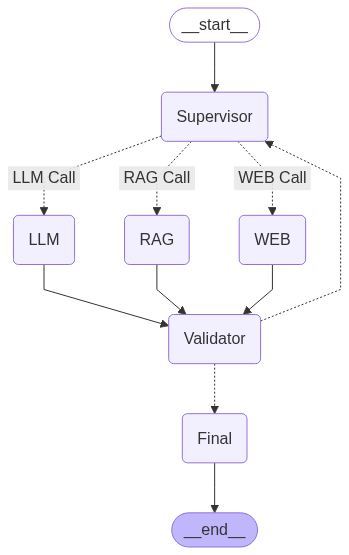

In [782]:
display(Image(app.get_graph().draw_mermaid_png()))


In [783]:
state = {"messages":["Hi!"]}

In [784]:
state = {"messages":["From Web tell me about RCB"]}

In [785]:
app.invoke(state)

Question:  From Web tell me about RCB
Parsed response:  Topic='Websurfing needed' Reasoning='The query explicitly requests information from the web, indicating a need for web surfing to answer the question about RCB.'
->ROUTER->
last_message: Websurfing needed
->WEB Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ['From Web tell me about RCB',
  'Websurfing needed',
  '**Royal Challengers Bengaluru**, formerly known as **Royal Challengers Bangalore**, commonly known as **RCB**, is a professional [franchise cricket](https://en.wikipedia.org/wiki/Cricket "Cricket") team based in [Bengaluru](https://en.wikipedia.org/wiki/Bengaluru "Bengaluru"), [Karnataka](https://en.wikipedia.org/wiki/Karnataka "Karnataka"), competing in the [Indian Premier League](https://en.wikipedia.org/wiki/Indian_Premier_League "Indian Premier League"). Founded in 2008 by [United [...] Spirits](https://en.wikipedia.org/wiki/United_Spirits "United Spirits"), currently managed by Prathamesh Mishra, the team is named after the liquor brand, [Royal Challenge](https://en.wikipedia.org/wiki/Royal_Challenge "Royal Challenge"). The [M. Chinnaswamy Stadium](https://en.wikipedia.org/wiki/M._Chinnaswamy_Stadium "M. Chinnaswamy Stadium") in Bengaluru is their home ground. It is the most popular and followed cricket franchis

In [792]:
state1={"messages":["Hi! my name is Vinay can you tell me today's weather in Bangalore from web?"]}

In [793]:
app.invoke(state1)

Question:  Hi! my name is Vinay can you tell me today's weather in Bangalore from web?
Parsed response:  Topic='Websurfing needed' Reasoning='The query explicitly asks for weather information from the web, indicating a need for web surfing to obtain the answer.'
->ROUTER->
last_message: Websurfing needed
->WEB Call->
->Validator->
->IN RETRY ROUTER->
->IN Final Node->


{'messages': ["Hi! my name is Vinay can you tell me today's weather in Bangalore from web?",
  'Websurfing needed',
  "Today's Weather in Bengaluru: In Bengaluru today, the weather is expected to be Mostly Cloudy with a maximum temperature of 27°C and a minimum of 22°C.",
  "today's weather in bengaluru: in bengaluru today, the weather is expected to be mostly cloudy with a maximum temperature of 27°c and a minimum of 22°c.",
  "✅ Final Answer: today's weather in bengaluru: in bengaluru today, the weather is expected to be mostly cloudy with a maximum temperature of 27°c and a minimum of 22°c."]}